In [1]:
# Importing libraries 
import os
import json
import datetime
import numpy as np
import pandas as pd
import skimage.draw
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf 
from keras.models import Model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import Mask RCNN
from mrcnn.visualize import display_instances
from mrcnn import model as modellib, utils
from mrcnn.config import Config
import mrcnn.mrcnnCustom as mrcnnCustom
import mrcnn.updatedUtils as updatedUtils

Using TensorFlow backend.


In [2]:
# Loading the dataset 
PATHS = {
    "root_dir": "",
    "checkpoint_path": "model/logs", 
    "trained_weights": "model/logs/petrol station20241001T2009/mask_rcnn_petrol station_0080.h5"
}

# Defining object name 
objectList = ["petrol station"]

In [3]:
class PredictionConfig(Config):
    NAME = "petrol station"
    
    # Max images per GPU in the testing phase is 1
    IMAGES_PER_GPU = 1

    # Background + object of interest
    NUM_CLASSES = 1 + 1     
    
    DETECTION_MIN_CONFIDENCE = 0.9

config_pred = PredictionConfig()

In [4]:
model = modellib.MaskRCNN(mode = "inference", model_dir=PATHS["checkpoint_path"], config=config_pred)
model.load_weights(PATHS["trained_weights"], by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








In [5]:
layers = model.get_trainable_layers()

for index, layer in enumerate(layers):
    try: 
        print(f"{index} {layer.name}: {layer}: {layer.output}")
    except: 
        print(f"Unable to load layer: {index}")

0 conv1: <keras.layers.convolutional.Conv2D object at 0x00000262A7D62CC8>: Tensor("conv1/BiasAdd:0", shape=(?, ?, ?, 64), dtype=float32)
1 bn_conv1: <mrcnn.model.BatchNorm object at 0x00000262A7C9A2C8>: Tensor("bn_conv1/FusedBatchNormV3:0", shape=(?, ?, ?, 64), dtype=float32)
2 res2a_branch2a: <keras.layers.convolutional.Conv2D object at 0x00000262A7DBC6C8>: Tensor("res2a_branch2a/BiasAdd:0", shape=(?, ?, ?, 64), dtype=float32)
3 bn2a_branch2a: <mrcnn.model.BatchNorm object at 0x00000262A7DBCC88>: Tensor("bn2a_branch2a/FusedBatchNormV3:0", shape=(?, ?, ?, 64), dtype=float32)
4 res2a_branch2b: <keras.layers.convolutional.Conv2D object at 0x00000262A7DD2848>: Tensor("res2a_branch2b/BiasAdd:0", shape=(?, ?, ?, 64), dtype=float32)
5 bn2a_branch2b: <mrcnn.model.BatchNorm object at 0x00000262A7DD5C88>: Tensor("bn2a_branch2b/FusedBatchNormV3:0", shape=(?, ?, ?, 64), dtype=float32)
6 res2a_branch2c: <keras.layers.convolutional.Conv2D object at 0x00000262A7DE9748>: Tensor("res2a_branch2c/BiasAd

In [6]:
imagePath = "dataset"
imageSubFolder = "test"
imageList = os.listdir(imagePath)
dataset = mrcnnCustom.CustomDataset()
dataset.load_custom(imagePath, imageSubFolder, objectList)
dataset.prepare()

In [7]:
dataset.image_ids

array([0, 1, 2, 3, 4, 5, 6])

In [8]:
inspect_id = 4
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config_pred, inspect_id) #, use_mini_mask=False)

In [9]:
molded_images, image_metas, windows = model.mold_inputs([image])

image_shape = molded_images[0].shape
for g in molded_images[1:]:
    assert g.shape == image_shape,\
        "After resizing, all images must have the same size. Check IMAGE_RESIZE_MODE and image sizes."

anchors = model.get_anchors(image_shape)
anchors = np.broadcast_to(anchors, (config_pred.BATCH_SIZE,) + anchors.shape)

In [10]:
image.shape

(1024, 1024, 3)

In [11]:
class MaskRCNNWrapper:
    def __init__(self, mask_rcnn_model):
        self.mask_rcnn_model = mask_rcnn_model  

    def summary(self):
        self.mask_rcnn_model.keras_model.summary()  

    def get_input_shape(self):
        return self.mask_rcnn_model.keras_model.input_shape

    def get_inputs(self):
        return self.mask_rcnn_model.keras_model.inputs 

In [12]:
wrapper = MaskRCNNWrapper(model)

wrapper.summary()
input_shape = wrapper.get_input_shape()
print("Input shape:", input_shape)
inputs = wrapper.get_inputs()
print("Model inputs:", inputs)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [13]:
def plot_feature_maps(layer): 
    feature_map_model = Model(inputs=wrapper.get_inputs(), outputs=layer.output)
    feature_maps = feature_map_model.predict([molded_images, image_metas, anchors])

    n_features = feature_maps.shape[-1] 
    size = feature_maps.shape[1]  


    plt.figure(figsize=(15, 15))
    for i in range(n_features):
        plt.subplot(16, 16, i + 1)  
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')  
        plt.axis('off')
    plt.tight_layout()
    plt.show()

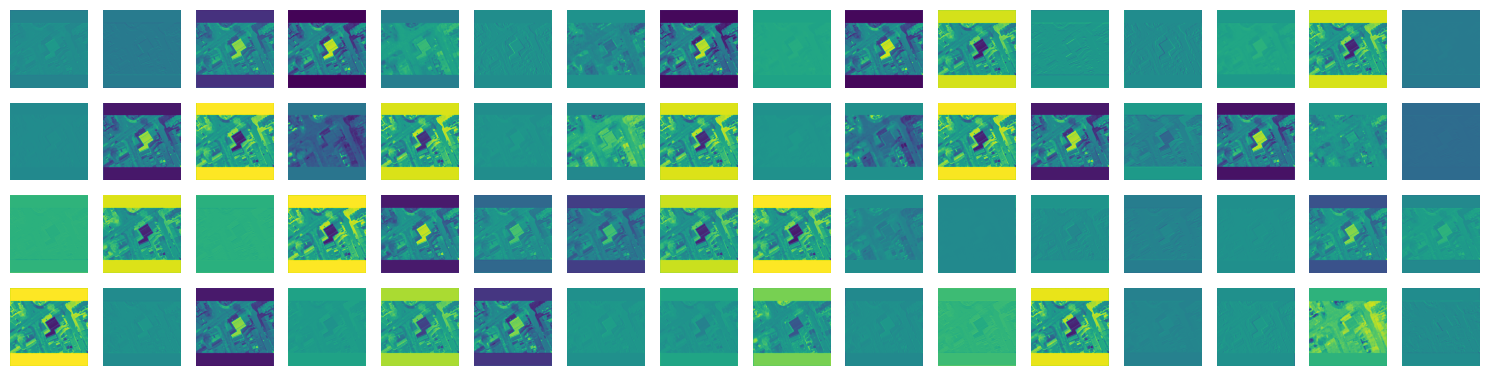

In [14]:
layer = layers[0] 
plot_feature_maps(layer)

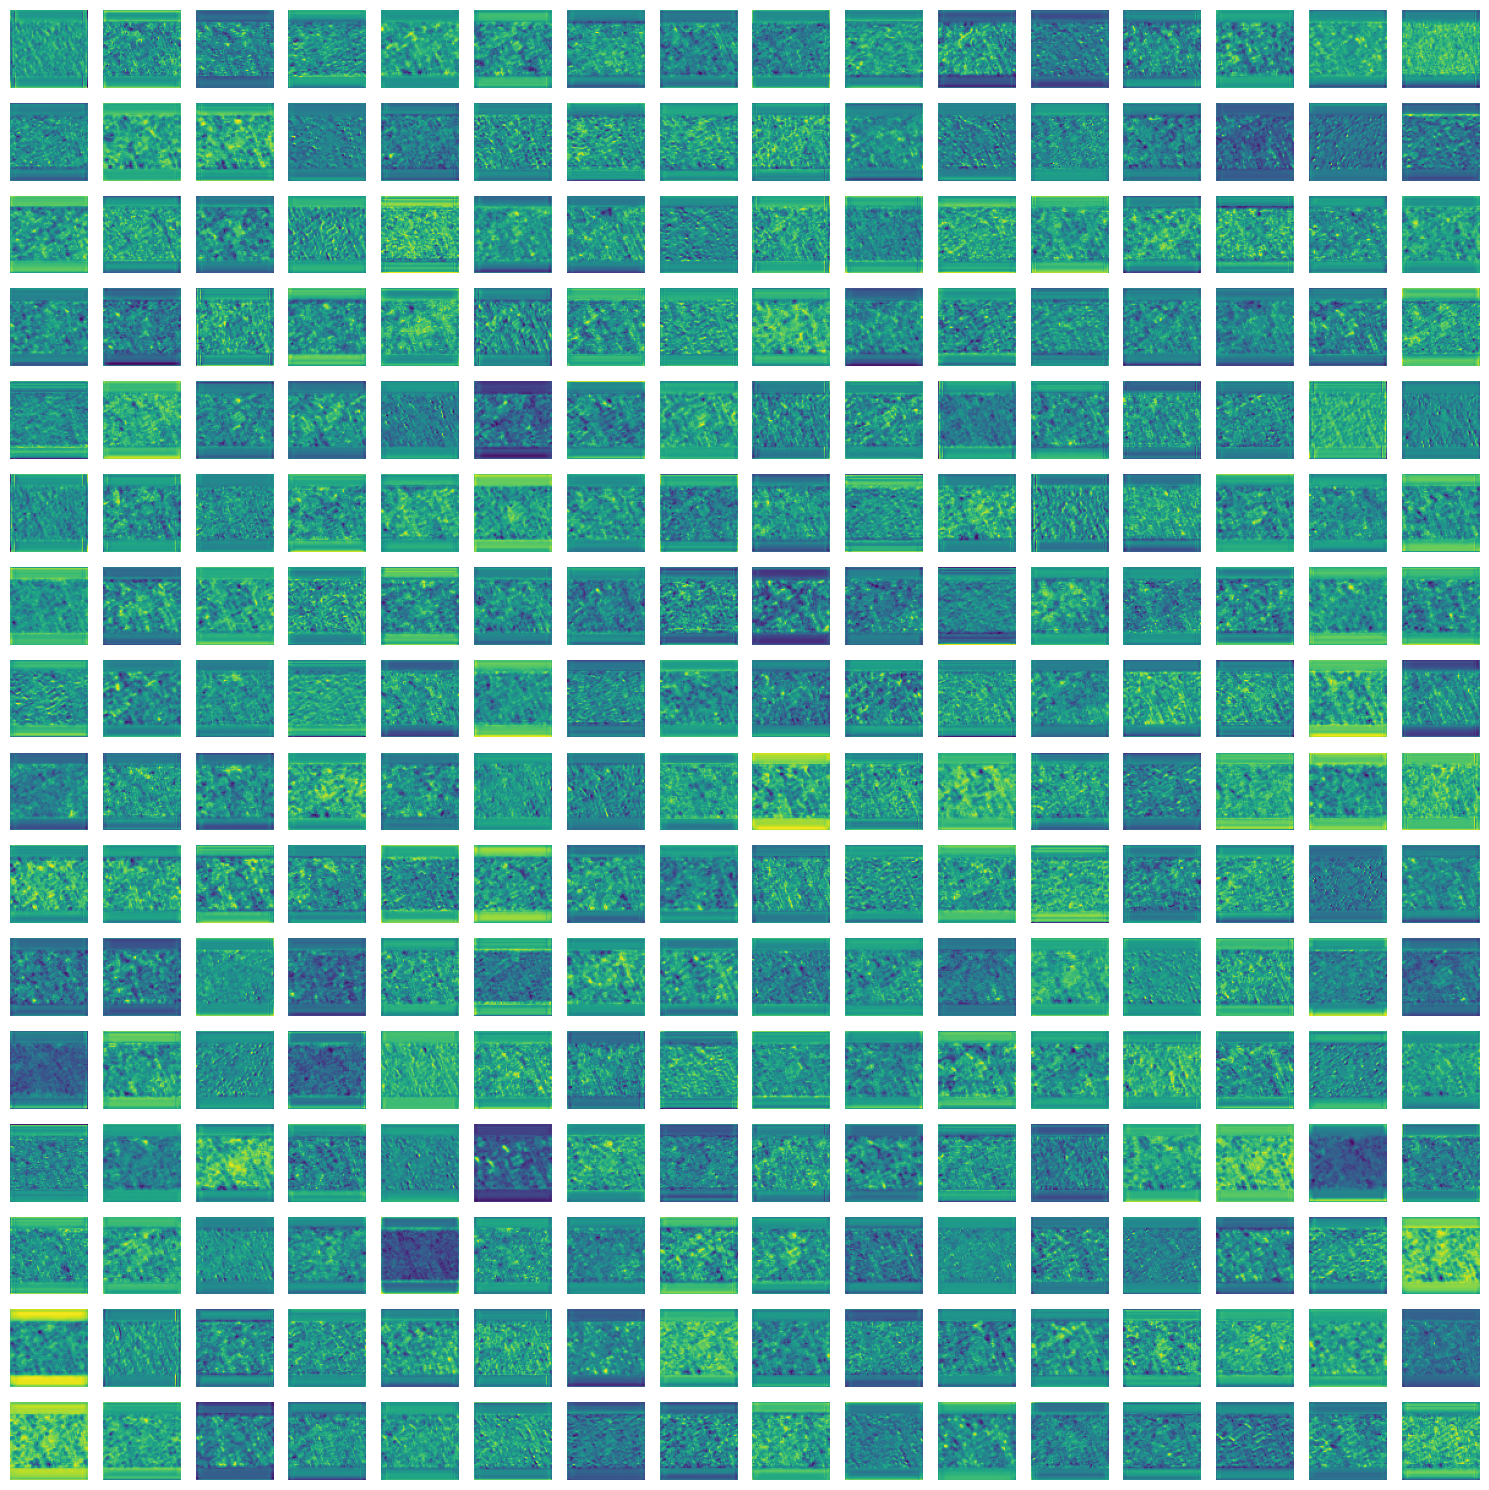

In [16]:
layer = layers[100] 
plot_feature_maps(layer)

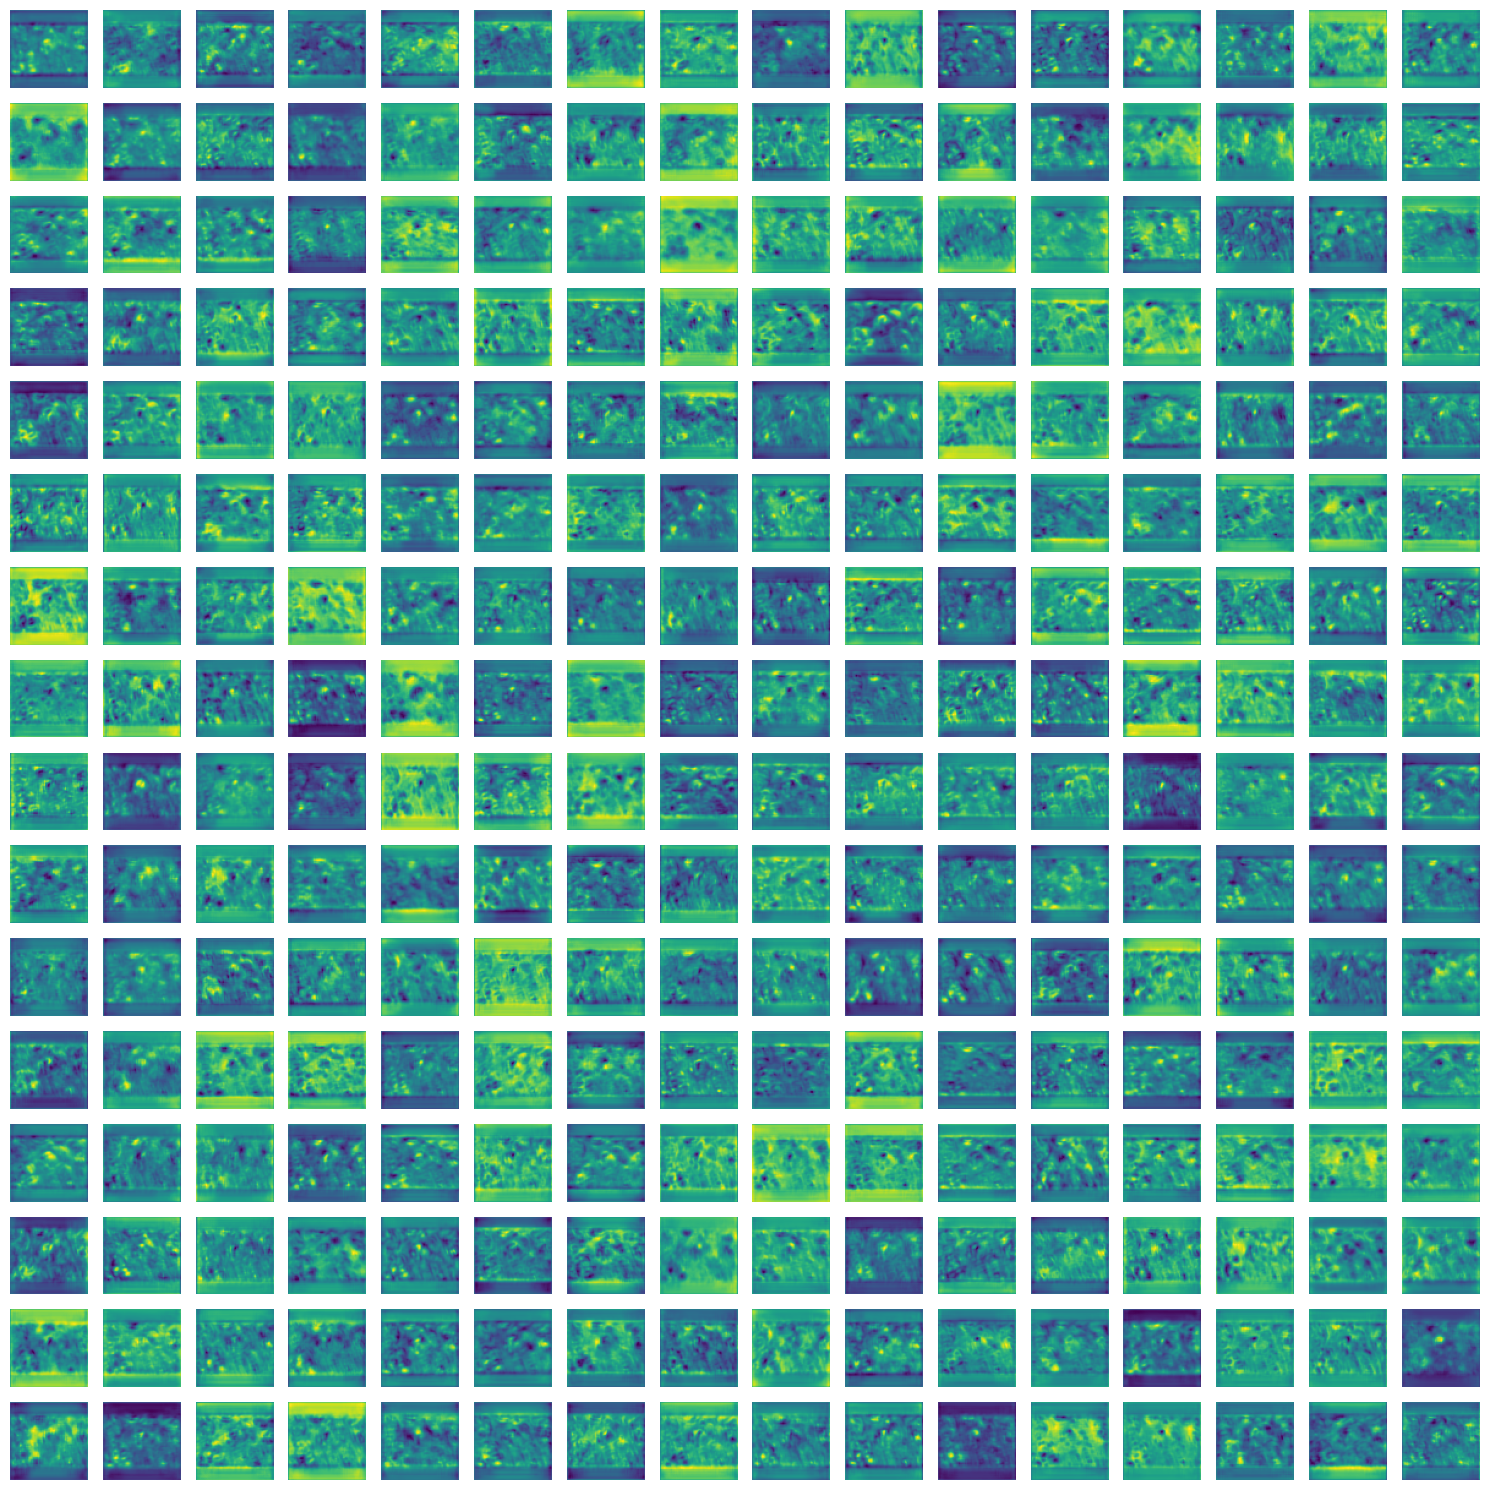

In [15]:
layer = layers[215] 
plot_feature_maps(layer)